In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
from PIL import Image
import urllib, cStringIO
# import cv2
from tensorflow.contrib import layers
import math

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 32


In [3]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}

image_names = attributes_by_image.keys()
attr_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    attr_vector[i] = [(1 if attrs[key] else 0) for key in keys]

def create_qs(train):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    attr_tensor = tf.convert_to_tensor(attr_vector, dtype=tf.float32)
    filename_q, attr_q = tf.train.slice_input_producer([filename_tensor, attr_tensor], num_epochs=None, shuffle=True)

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218
    # image = tf.image.rgb_to_grayscale(image)

    def resize_image(image):
        # image = tf.random_crop(image, [192, 160, 3])
        # return image
        image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
        img_reshaped = tf.reshape(image, [1, 160, 160, 3])
        image = tf.image.resize_bilinear(img_reshaped, [IMAGE_SIZE, IMAGE_SIZE])
        return tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, 3])
    image = resize_image(image)

    def distort_image(image):
        # noise_amt = tf.abs(tf.random_normal([], stddev=0.2))
        # distorted_image = image + tf.random_uniform([64, 64, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.6, upper=1.6)
        # distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    images_batch, attrs_batch = tf.train.shuffle_batch([distort_image(image), attr_q], batch_size=BATCH_SIZE, capacity=BATCH_SIZE*20, min_after_dequeue=BATCH_SIZE*10)
    return images_batch, attrs_batch

images_batch, attrs_batch = create_qs(True)


In [4]:
keys

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [5]:
initializer = tf.truncated_normal_initializer(0.00, 0.02)

def lrelu(x):
    # leaky relu
    alpha = 0.1
    return tf.maximum(alpha*x,x)

def identity(x): return x

n_layers = int(round(math.log(IMAGE_SIZE) / math.log(2)))
Z_SIZE = 128

def encoder(img):
    with tf.variable_scope('encoder'):
        for i in xrange(n_layers):
            n_channels = min(256, 16 * 2 ** i)
            img = layers.conv2d(img,
                      n_channels, 
                      scope='enc_'+str(i), 
                      kernel_size=5, 
                      activation_fn=lrelu, 
                      stride=2,
                      normalizer_fn=layers.batch_norm, 
                      weights_initializer=initializer)
            img = layers.conv2d(img, n_channels, scope='enc_1x1_'+str(i), kernel_size=1, stride=1, weights_initializer=initializer)
            img = layers.dropout(img, 0.8)
        flat = layers.flatten(img)
        z_mean = layers.fully_connected(flat, Z_SIZE, activation_fn=identity, biases_initializer=initializer)
        z_log_stddev = layers.fully_connected(flat, Z_SIZE, activation_fn=identity, biases_initializer=initializer)
        return z_mean, z_log_stddev

def decoder(z, condition):
    with tf.variable_scope('decoder'):
        zc = tf.concat([z, condition], axis=1)
        img = tf.reshape(zc, [-1, 1, 1, zc.get_shape()[-1].value])
        for i in xrange(n_layers):
            n_channels = min(256, 16 * 2 ** (n_layers - i - 1))
            img = layers.conv2d_transpose(img, 
                        n_channels, 
                        scope='dec_'+str(i), 
                        kernel_size=5, 
                        activation_fn=lrelu, 
                        normalizer_fn=layers.batch_norm,
                        stride=2,
                        weights_initializer=initializer)
            img = layers.conv2d(img, n_channels, scope='dec_1x1_'+str(i), kernel_size=1, stride=1, activation_fn=lrelu, weights_initializer=initializer)
        final = layers.conv2d(img, 
                              3, 
                              scope='final', 
                              activation_fn=tf.tanh, 
                              stride=1, 
                              kernel_size=1, 
                              biases_initializer=initializer)
        return final

def discriminator(img, cond):
    with tf.variable_scope('discriminator'):
        cond_vec_float = tf.reshape(tf.cast(cond_vec, tf.float32), [1, 1, 1, -1])
        for i in xrange(n_layers):
            # concat the cond vec to the image, tiled:
            b, h, w, _ = [dim.value for dim in img.get_shape()]
            tiling = tf.stack([b,h,w,1])
            cond_vec_resized = tf.tile(cond_vec_float, tiling)
            img = tf.concat([img, cond_vec_resized], axis=3)
            
            n_channels = min(256, 16 * 2 ** i)
            img = layers.conv2d(img,
                      n_channels, 
                      scope='disc_'+str(i), 
                      kernel_size=4, 
                      activation_fn=lrelu, 
                      stride=2,
                      normalizer_fn=layers.batch_norm, 
                      weights_initializer=initializer)
            img = layers.conv2d(img, n_channels, scope='enc_1x1_'+str(i), kernel_size=1, stride=1, activation_fn=lrelu, weights_initializer=initializer)
        flat = layers.flatten(img)
        fc1 = layers.fully_connected(flat, 64, activation_fn=lrelu, biases_initializer=initializer)
        score = layers.fully_connected(fc1, 1, activation_fn=identity)
        return score
    
def l2_loss(y, y_):
    return (y - y_) * (y - y_)

def kl_divergence(z_mean, z_log_stddev):
    stddev = tf.exp(z_log_stddev)
    epsilon = 1e-8
    return tf.reduce_mean(0.5 * (tf.square(z_mean) + tf.square(stddev) - 2.0 * tf.log(stddev + epsilon) - 1.0))

USE_GAN = False

scopename = 'cvae'
with tf.variable_scope(scopename):
    attributes = ['Male', 'Smiling']
    attr_indices = [keys.index(attr) for attr in attributes]
    cond_vec = tf.transpose(tf.gather(tf.transpose(attrs_batch, [1, 0]), attr_indices), [1, 0])
    
    def sample_z(z_mean, z_log_stddev):
        samples = tf.random_normal(tf.shape(z_log_stddev), 0, 1, dtype=tf.float32)
        return z_mean + samples * tf.exp(z_log_stddev)
        
    z_mean, z_log_stddev = encoder(images_batch)
    z = sample_z(z_mean, z_log_stddev)
    reconstruction = decoder(z, cond_vec)
    
    real_disc_output = discriminator(images_batch, cond_vec)
    fake_disc_output = discriminator(reconstruction, cond_vec)
#     reals_are_real = tf.reduce_mean(l2_loss(real_disc_output, tf.ones_like(real_disc_output)))
#     fakes_are_real = tf.reduce_mean(l2_loss(fake_disc_output, tf.ones_like(fake_disc_output)))
#     fakes_are_fake = tf.reduce_mean(l2_loss(fake_disc_output, -tf.ones_like(fake_disc_output)))
    # the critic outputs large positive numbers for real images, and larhe negative numbers for fake ones:
    reals_are_real = tf.reduce_mean(-real_disc_output)
    fakes_are_real = tf.reduce_mean(-fake_disc_output)
    fakes_are_fake = tf.reduce_mean(fake_disc_output)
    
    diff_loss = tf.reduce_mean(l2_loss(images_batch, reconstruction))
    kl = kl_divergence(z_mean, z_log_stddev)
    gen_loss = diff_loss + kl + (fakes_are_real if USE_GAN else 0)
    
    disc_loss = reals_are_real + fakes_are_fake
    
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/discriminator')
    gen_vars = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v not in disc_vars]
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    train_gen = tf.train.AdamOptimizer(0.001).minimize(gen_loss, var_list=gen_vars, global_step=global_step)
    
    train_disc_op = tf.train.RMSPropOptimizer(0.0001).minimize(disc_loss, var_list=disc_vars)
    weight_clip_op = tf.group(*[w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in disc_vars])
    train_disc = tf.group(weight_clip_op, train_disc_op)

print 'ok'

ok


In [ ]:
session = None
saver = None
save_path = None

def create_session():
    global session
    global saver
    global save_path
    
    if session: session.close()
    
    session = tf.InteractiveSession()

    save_path = None # 'models/lsgan-face-cond-1'
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    session.run(init_op)
    tf.train.start_queue_runners(sess=session)

    import os
    saver = None
    if save_path:
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(save_path)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print 'Restored from checkpoint', ckpt.model_checkpoint_path
        else:
            print 'Did not restore from checkpoint'
    else:
        print 'Will not save progress'

create_session()


Will not save progress


Step: 0, gen loss: 0.308919489384


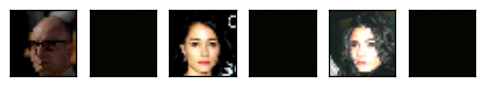

Step: 200, gen loss: 0.136804273389
Step: 400, gen loss: 0.122283389755
Step: 600, gen loss: 0.122501263767
Step: 800, gen loss: 0.121023814604


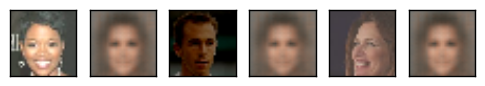

Step: 1000, gen loss: 0.119066840485
Step: 1200, gen loss: 0.121282434724
Step: 1400, gen loss: 0.118976960294
Step: 1600, gen loss: 0.118707499392


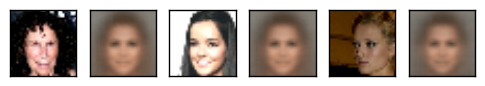

Step: 1800, gen loss: 0.11908375293
Step: 2000, gen loss: 0.118596095853
Step: 2200, gen loss: 0.119575675689
Step: 2400, gen loss: 0.118602902442


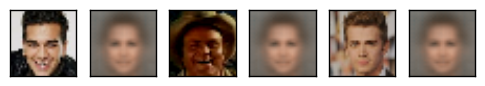

Step: 2600, gen loss: 0.118486823253
Step: 2800, gen loss: 0.117175482735
Step: 3000, gen loss: 0.116619128846
Step: 3200, gen loss: 0.118811867572


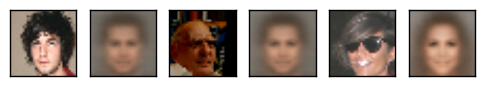

Step: 3400, gen loss: 0.118983279206
Step: 3600, gen loss: 0.119093310833
Step: 3800, gen loss: 0.118120470084
Step: 4000, gen loss: 0.118809244856


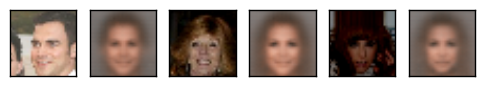

Step: 4200, gen loss: 0.11937905781
Step: 4400, gen loss: 0.118538792208
Step: 4600, gen loss: 0.119172353595
Step: 4800, gen loss: 0.118720411696


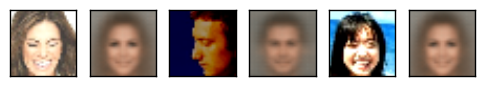

Step: 5000, gen loss: 0.116985800862
Step: 5200, gen loss: 0.120223876089
Step: 5400, gen loss: 0.118685267866
Step: 5600, gen loss: 0.118676749989


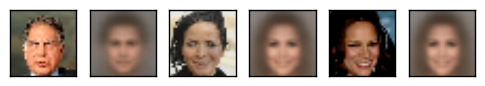

Step: 5800, gen loss: 0.117627331614
Step: 6000, gen loss: 0.118766046241
Step: 6200, gen loss: 0.117331031039
Step: 6400, gen loss: 0.119825200588


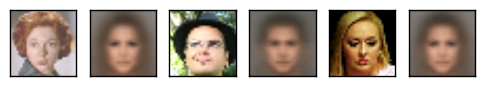

Step: 6600, gen loss: 0.116423643306
Step: 6800, gen loss: 0.119695915245
Step: 7000, gen loss: 0.11726274088
Step: 7200, gen loss: 0.118981446791


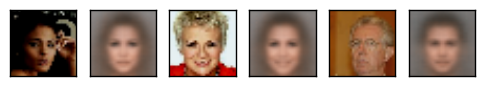

Step: 7400, gen loss: 0.11664942421
Step: 7600, gen loss: 0.117046240829
Step: 7800, gen loss: 0.118050149083
Step: 8000, gen loss: 0.118380530402


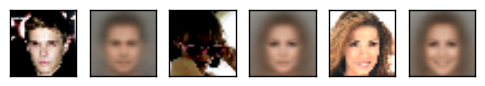

Step: 8200, gen loss: 0.117173385248
Step: 8400, gen loss: 0.116603595093
Step: 8600, gen loss: 0.122851591893
Step: 8800, gen loss: 0.118779978231


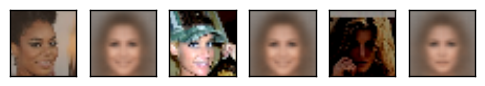

Step: 9000, gen loss: 0.120513192602
Step: 9200, gen loss: 0.11961593084
Step: 9400, gen loss: 0.118708258756
Step: 9600, gen loss: 0.119865800776


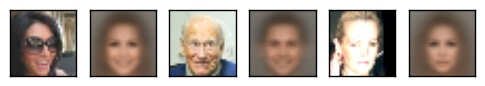

Step: 9800, gen loss: 0.119222468883
Step: 10000, gen loss: 0.118733805679
Step: 10200, gen loss: 0.118568157814
Step: 10400, gen loss: 0.117806720212


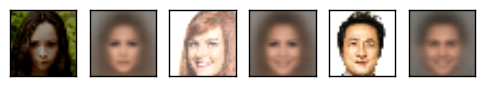

Step: 10600, gen loss: 0.119863880873
Step: 10800, gen loss: 0.118182027452
Step: 11000, gen loss: 0.116464163736
Step: 11200, gen loss: 0.118885834292


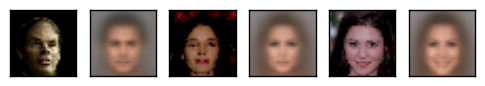

Step: 11400, gen loss: 0.119128879458
Step: 11600, gen loss: 0.118117358014
Step: 11800, gen loss: 0.117686288506
Step: 12000, gen loss: 0.11819454208


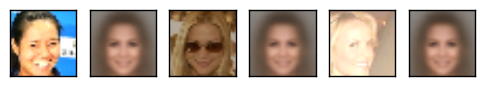

Step: 12200, gen loss: 0.116239353083
Step: 12400, gen loss: 0.119281071536
Step: 12600, gen loss: 0.118509206213
Step: 12800, gen loss: 0.117262705564


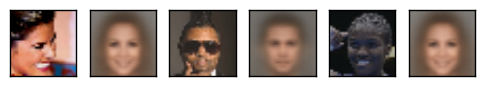

Step: 13000, gen loss: 0.118210329115
Step: 13200, gen loss: 0.119150044806
Step: 13400, gen loss: 0.120406660549
Step: 13600, gen loss: 0.11688865345


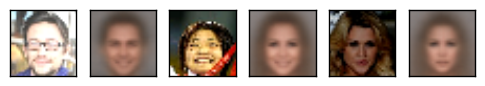

Step: 13800, gen loss: 0.118930056766
Step: 14000, gen loss: 0.119121091366
Step: 14200, gen loss: 0.119128396623
Step: 14400, gen loss: 0.118138775378


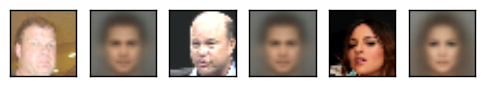

Step: 14600, gen loss: 0.118046080582
Step: 14800, gen loss: 0.119321613684
Step: 15000, gen loss: 0.116923651081
Step: 15200, gen loss: 0.117841040678


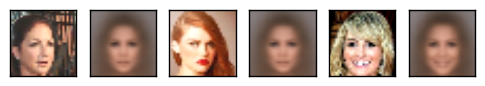

Step: 15400, gen loss: 0.119142893106
Step: 15600, gen loss: 0.117682628781
Step: 15800, gen loss: 0.119456207268
Step: 16000, gen loss: 0.116571961045


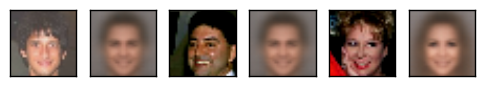

Step: 16200, gen loss: 0.118755235635
Step: 16400, gen loss: 0.118132576197
Step: 16600, gen loss: 0.119284010567
Step: 16800, gen loss: 0.117998824492


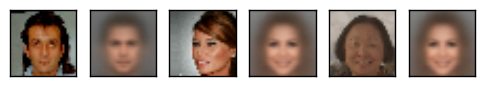

Step: 17000, gen loss: 0.120629856475
Step: 17200, gen loss: 0.117925294228
Step: 17400, gen loss: 0.11767328497
Step: 17600, gen loss: 0.117994829528


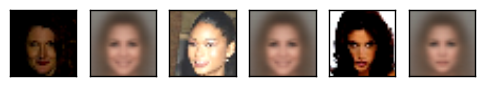

Step: 17800, gen loss: 0.115643699877
Step: 18000, gen loss: 0.118189261258
Step: 18200, gen loss: 0.119308557995
Step: 18400, gen loss: 0.118238680139


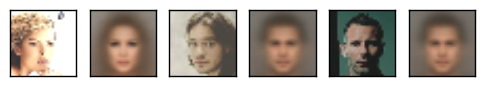

Step: 18600, gen loss: 0.116391542517
Step: 18800, gen loss: 0.118594405055
Step: 19000, gen loss: 0.118436298333
Step: 19200, gen loss: 0.117865449786


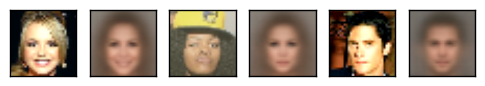

Step: 19400, gen loss: 0.115139979683
Step: 19600, gen loss: 0.120522704795
Step: 19800, gen loss: 0.115073144436
Step: 20000, gen loss: 0.119966941178


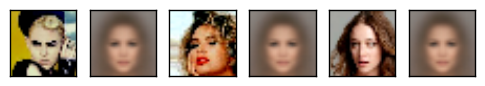

Step: 20200, gen loss: 0.119629862048
Step: 20400, gen loss: 0.118772781268
Step: 20600, gen loss: 0.117014962509
Step: 20800, gen loss: 0.11704174988


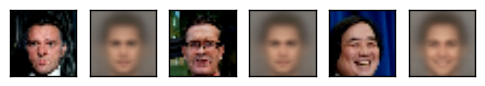

Step: 21000, gen loss: 0.117380548231
Step: 21200, gen loss: 0.118813321851
Step: 21400, gen loss: 0.119645657428
Step: 21600, gen loss: 0.119062596224


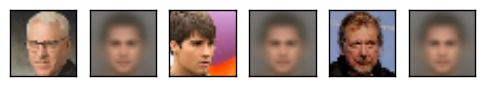

Step: 21800, gen loss: 0.119424519017
Step: 22000, gen loss: 0.118347543441
Step: 22200, gen loss: 0.116064417176
Step: 22400, gen loss: 0.118172984086


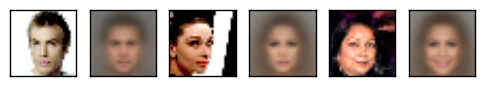

Step: 22600, gen loss: 0.117638998739
Step: 22800, gen loss: 0.118080828786
Step: 23000, gen loss: 0.116856948547
Step: 23200, gen loss: 0.11649121698


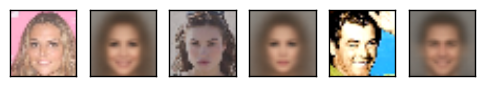

Step: 23400, gen loss: 0.117910647914
Step: 23600, gen loss: 0.115198894255
Step: 23800, gen loss: 0.116313854754
Step: 24000, gen loss: 0.116906482801


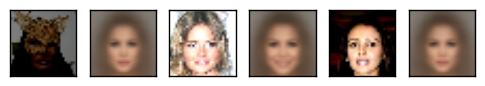

Step: 24200, gen loss: 0.118954602815
Step: 24400, gen loss: 0.118142111823
Step: 24600, gen loss: 0.118299984038
Step: 24800, gen loss: 0.119592376594


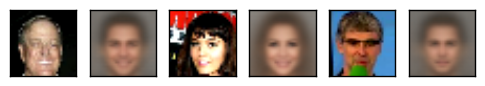

Step: 25000, gen loss: 0.11891913496
Step: 25200, gen loss: 0.116042657085
Step: 25400, gen loss: 0.11837566115
Step: 25600, gen loss: 0.118039502911


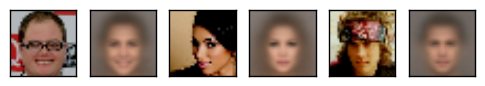

Step: 25800, gen loss: 0.1193241762
Step: 26000, gen loss: 0.119668533504
Step: 26200, gen loss: 0.120717886463
Step: 26400, gen loss: 0.11615527235


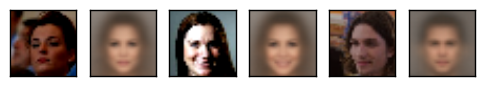

Step: 26600, gen loss: 0.117560162619
Step: 26800, gen loss: 0.120419830158
Step: 27000, gen loss: 0.118898674957
Step: 27200, gen loss: 0.118266998045


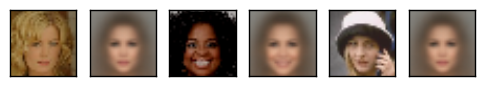

Step: 27400, gen loss: 0.117814371772


In [ ]:
def avg(x): return sum(x) / float(len(x))
def flatten(l):
    return [item for sublist in l for item in sublist]

savecount = 0

gen_losses = []
disc_losses = []

while True:
    examples_ = None
    step_ = global_step.eval()
    
    feed = {}
    
    if USE_GAN:
        _, _, gen_loss_, disc_loss_ = session.run([train_gen, train_disc, gen_loss, disc_loss], feed_dict=feed)
        gen_losses.append(gen_loss_)
        disc_losses.append(disc_loss_)
    else:
        _, gen_loss_ = session.run([train_gen, gen_loss], feed_dict=feed)
        gen_losses.append(gen_loss_)
    
    if step_ % 200 == 0:
        if USE_GAN:
            print "Step: {}, disc loss: {}, gen loss: {}".format(step_, avg(disc_losses), avg(gen_losses))
        else:
            print "Step: {}, gen loss: {}".format(step_, avg(gen_losses))
        disc_losses = []
        gen_losses = []
        
        if step_ % 800 == 0:
            examples_, originals_ = session.run([reconstruction[:3], images_batch[:3]])
            imshow_multi(flatten(zip(originals_, examples_)))
        
        if step_ % 2000 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_)
                print 'Saved'
                savecount += 1
                if savecount > 4:
                    create_session()
                    savecount = 0


In [ ]:
kl_loss_, diff_loss_ = session.run([kl, diff_loss])
print kl_loss_, diff_loss_